In [145]:
import numpy             as np
import gvar              as gv
import matplotlib.pyplot as plt
import pandas            as pd
import seaborn           as sns
import lsqfit

In [146]:
from b2heavy                             import FnalHISQMetadata
from b2heavy.TwoPointFunctions.types2pts import CorrelatorIO, Correlator, plot_effective_coeffs
from b2heavy.TwoPointFunctions.fitter    import StagFitter

In [147]:
BINSIZE = {
    'MediumCoarse':13,
    'Coarse-2':    16,
    'Coarse-1':    11,
    'Coarse-Phys': 19,
    'Fine-1':      16,
    'Fine-Phys':   16,
    'SuperFine':   22
}

In [167]:
ENSEMBLE = 'Fine-1'
MOMENTUM = '222'
DATA_DIR = '/Users/pietro/code/data_analysis/BtoD/Alex/'
SMLIST   = ['1S-1S','d-d','d-1S']
trange = (7,23)

In [168]:
io = CorrelatorIO(ENSEMBLE,'Dst',MOMENTUM,PathToDataDir=DATA_DIR)

corr = Correlator(io,smearing=['1S-1S','d-d','d-1S'],jkBin=0)
x,y, fulldata = corr.format(trange=trange,flatten=True,alljk=True)

corr = Correlator(io,smearing=['1S-1S','d-d','d-1S'],jkBin=BINSIZE[ENSEMBLE])
x,y, data = corr.format(trange=trange,flatten=True,alljk=True)

4.7e+17
2.5e+17
3.5e+05
3.2e+03
1.4e+03
7.0e+02
3.7e+02
4.3e+02
3.5e+02
2.2e+02


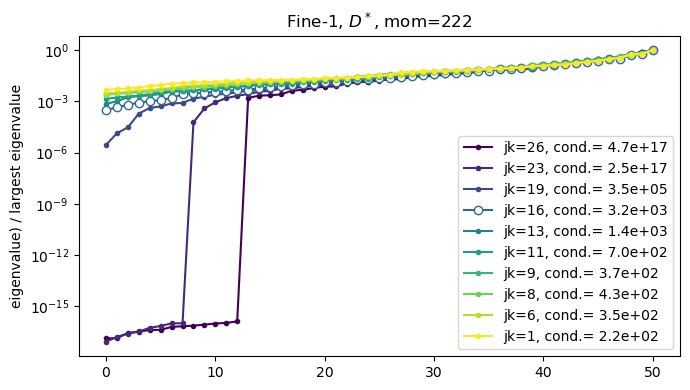

In [169]:
f, ax = plt.subplots(figsize=(7, 4))

jks = [1,6,8,9,11,13,16,19,23,26]

cmap = plt.get_cmap('viridis',len(jks))
cov_specs = dict(shrink=True, scale=True)

for i,jk in enumerate(reversed(jks)):
    corr = Correlator(io,smearing=['1S-1S','d-d','d-1S'],jkBin=jk)
    x,y, data = corr.format(trange=trange,flatten=True,alljk=True,**cov_specs)    

    cov = np.cov(data.T) * (data.shape[0]-1 if jk!=0 else 1.)
    cdiag = np.diag(1./np.sqrt(np.diag(cov)))
    cor = cdiag @ cov @ cdiag

    condn = f'{np.linalg.cond(cor):.1e}'
    print(condn)

    eval,evec = np.linalg.eigh(cor)

    y = sorted(abs(eval))/max(eval)

    if jk==BINSIZE[ENSEMBLE]:
        ax.plot(np.arange(len(eval)), y, marker='o', mfc='w', color=cmap(i), label=f'{jk=}, cond.= {condn}')
    else:
        ax.plot(np.arange(len(eval)), y, marker='.', color=cmap(i), label=f'{jk=}, cond.= {condn}')

ax.set_yscale('log')
ax.legend()
ax.set_ylabel(r'eigenvalue) / largest eigenvalue')
ax.set_title(fr'{ENSEMBLE}, $D^*$, mom={MOMENTUM}')

plt.tight_layout()
plt.savefig('/Users/pietro/Desktop/corr_spectrum.pdf')

We can see from that that for binsize $\geq 9$ a large gap between the eigenvalues forms. It is very likely that low modes gets heavily underestimated.

We can see in fact using a bootstrap analysis, an svd cut of 0.05 is suggested.

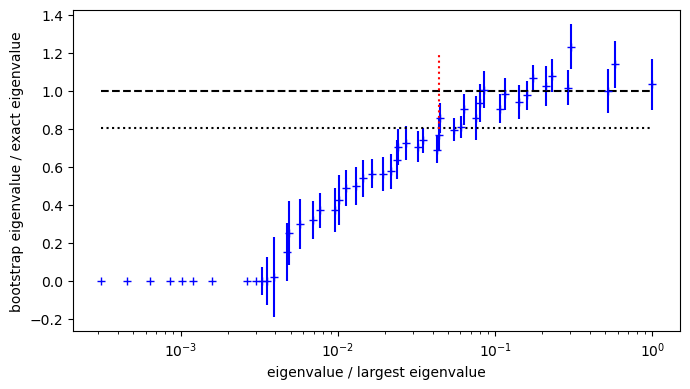

In [170]:
corr = Correlator(io,smearing=['1S-1S','d-d','d-1S'],jkBin=BINSIZE[ENSEMBLE])
x,ydata, ysamples = corr.format(trange=trange,flatten=True,alljk=True)   
svd = gv.dataset.svd_diagnosis(ysamples)

f, ax = plt.subplots(figsize=(7, 4))

svd.plot_ratio()
eps = svd.svdcut

eps

plt.tight_layout()
plt.savefig('/Users/pietro/Desktop/svd.pdf')

# Find optimal `eps`

In [171]:
corr = Correlator(io,smearing=['1S-1S','d-d','d-1S'],jkBin=19)
cov_specs = dict(shrink=True, scale=True)
x,y, data = corr.format(trange=trange,flatten=True,alljk=True,**cov_specs)    

cov = np.cov(data.T) * ((data.shape[0]-1) if jk!=0 else 1.)
cdiag = np.diag(1./np.sqrt(np.diag(cov)))
cor = cdiag @ cov @ cdiag

eval,evec = np.linalg.eigh(cor)
y = sorted(abs(eval))/max(eval)

In [178]:
I=0
for i,r in enumerate((y/np.roll(y,1))[1:]):
    if r>1e+05:
        I=i+1
        break
eps = min(y[I:])
eps = sorted(eval)[I]

I

0

In [177]:
(y/np.roll(y,1))[1:]

array([4.77949977, 2.23459493, 6.32945049, 2.15292447, 1.23243205,
       1.49038712, 1.06624102, 1.81558466, 1.24789251, 1.36353976,
       1.10207329, 1.23129333, 1.25132652, 1.09057225, 1.10234028,
       1.19734242, 1.22311715, 1.18247398, 1.13520156, 1.21378812,
       1.09370983, 1.18944823, 1.0343358 , 1.13301375, 1.18850713,
       1.06693606, 1.15613217, 1.07534616, 1.15880535, 1.17243388,
       1.05702692, 1.16216943, 1.17258973, 1.03041527, 1.14900921,
       1.02868095, 1.22173346, 1.19626515, 1.09659206, 1.12914434,
       1.23635589, 1.14344265, 1.12791157, 1.24296829, 1.13592102,
       1.06403424, 1.30318108, 1.42737854, 1.3967199 , 1.26611611])

# Cycle over svd

Let's try to see the effect on the quality of the fit on the change of the SVD cut parameter

In [159]:
io   = CorrelatorIO(ENSEMBLE,'Dst',MOMENTUM,PathToDataDir=DATA_DIR)
stag = StagFitter(
    io       = io,
    jkBin    = BINSIZE[ENSEMBLE],
    smearing = ['1S-1S','d-d','d-1S'] 
)
cov_specs = dict(
    cutsvd = eps,
)
effm,effa = stag.meff(trange=(13,19),variant='cosh', **cov_specs)

/Users/pietro/code/software/B2heavy/b2heavy/TwoPointFunctions/types2pts.py:38: RuntimeWarning: invalid value encountered in sqrt
  m = np.arccosh( (y[(it+1)%len(y)]+y[(it-1)%len(y)])/y[it]/2 )
/Users/pietro/code/software/B2heavy/b2heavy/TwoPointFunctions/types2pts.py:38: RuntimeWarning: invalid value encountered in log
  m = np.arccosh( (y[(it+1)%len(y)]+y[(it-1)%len(y)])/y[it]/2 )
/Users/pietro/code/software/B2heavy/b2heavy/TwoPointFunctions/types2pts.py:38: RuntimeWarning: invalid value encountered in arccosh
  m = np.arccosh( (y[(it+1)%len(y)]+y[(it-1)%len(y)])/y[it]/2 )


In [165]:
r = []
# for svd in [0.0001,0.001,0.01,eps]:
# for svd in y[I-2:I+5]:
for svd in [eps]:
    cov_specs = dict(cutsvd=svd,scale=True,shrink=True)
    # cov_specs = dict(scale=True,shrink=True)

    io   = CorrelatorIO(ENSEMBLE,'Dst',MOMENTUM,PathToDataDir=DATA_DIR)
    stag = StagFitter(io,smearing=['1S-1S','d-d','d-1S'],jkBin=BINSIZE[ENSEMBLE])

    effm,effa = stag.meff(trange=(13,19),variant='cosh', **cov_specs)
    pr = stag.priors(3,Meff=effm, Aeff=effa)

    stag.fit(3,trange,priors=pr,**cov_specs)
    res = stag.fit_result(3,trange, priors=pr, verbose=False)

    r.append(dict(
        svd=svd,
        E0=res['fit'].p['E'][0],
        Z_1S_Par=res['fit'].p['Z_1S_Par'][0],
        Z_1S_Bot=res['fit'].p['Z_1S_Bot'][0],
        Z_d_Par=res['fit'].p['Z_d_Par'][0],
        Z_d_Bot=res['fit'].p['Z_d_Bot'][0],
        chiexp=res['chiexp'],
        chibar=res['chi2']/res['chiexp'],
        pval=res['pvalue']
    ))

/Users/pietro/code/software/B2heavy/b2heavy/TwoPointFunctions/types2pts.py:38: RuntimeWarning: invalid value encountered in sqrt
  m = np.arccosh( (y[(it+1)%len(y)]+y[(it-1)%len(y)])/y[it]/2 )
/Users/pietro/code/software/B2heavy/b2heavy/TwoPointFunctions/types2pts.py:38: RuntimeWarning: invalid value encountered in log
  m = np.arccosh( (y[(it+1)%len(y)]+y[(it-1)%len(y)])/y[it]/2 )
/Users/pietro/code/software/B2heavy/b2heavy/TwoPointFunctions/types2pts.py:38: RuntimeWarning: invalid value encountered in arccosh
  m = np.arccosh( (y[(it+1)%len(y)]+y[(it-1)%len(y)])/y[it]/2 )


In [166]:
pd.DataFrame(r)

,svd,E0,Z_1S_Par,Z_1S_Bot,Z_d_Par,Z_d_Bot,chiexp,chibar,pval
0,0.155444,0.8473(42),0.396(34),0.380(34),-2.347(40),-2.367(42),47.569198,0.6064629466077469,0.6091


In [161]:
pd.DataFrame(r)

,svd,E0,Z_1S_Par,Z_1S_Bot,Z_d_Par,Z_d_Bot,chiexp,chibar,pval
0,1.207668e-16,0.8454(28),0.377(30),0.363(28),-2.369(33),-2.389(35),150.665759,1.1122256051944421,0.0
1,2.366416e-16,0.8454(28),0.377(30),0.363(28),-2.369(33),-2.389(35),150.665759,1.1122256051944421,0.0
2,3.557555e-03,0.8454(28),0.377(30),0.363(28),-2.369(33),-2.389(35),150.665759,1.1122256051944421,0.0
3,4.429598e-03,0.8454(28),0.377(30),0.363(28),-2.369(33),-2.389(35),150.665759,1.1122256051944421,0.0
4,5.118225e-03,0.8454(28),0.377(30),0.363(28),-2.369(33),-2.389(35),150.665759,1.1122256051944421,0.0
5,5.646521e-03,0.8454(28),0.377(30),0.363(28),-2.369(33),-2.389(35),150.665759,1.1122256051944421,0.0
6,6.505907e-03,0.8454(28),0.377(30),0.363(28),-2.369(33),-2.389(35),150.665759,1.1122256051944421,0.0
